ViT Model trained on FER2013 from https://huggingface.co/trpakov/vit-face-expression

In [54]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

In [61]:
processor

ViTImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "do_rgb_to_grayscale": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [55]:
import numpy as np

In [56]:
processor.do_convert_rgb = True
processor.do_rgb_to_grayscale = True

Download dataset from https://figshare.com/articles/figure/DVM-CAR_Dataset/19586296/1?file=34792480
Place under `data/images`

In [57]:
TEST_IMAGE_PATH = "data/images/confirmed_fronts/Lexus/2017/Lexus$$RX 450h$$2017$$Red$$48_24$$468$$image_1.jpg"
CLASS_INDEX = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

In [58]:
from PIL import Image

def predict_expression(image_path):
    # Open the image
    image = Image.open(image_path)

    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt")
    
    # Image after processing
    image_tensor = inputs['pixel_values'][0]  # Assuming batch size 1

    # Convert from CHW to HWC format
    image_tensor = image_tensor.permute(1, 2, 0)

    # Denormalize the image
    mean = torch.tensor(processor.image_mean).view(1, 1, 3)
    std = torch.tensor(processor.image_std).view(1, 1, 3)
    image_tensor = image_tensor * std + mean

    # Clip values to be between 0 and 1
    image_tensor = torch.clamp(image_tensor, 0, 1)

    # Convert to numpy array and then to uint8
    image_array = (image_tensor.numpy() * 255).astype(np.uint8)

    # Create PIL Image
    pil_image = Image.fromarray(image_array)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    predicted_class_idx = outputs.logits.argmax(-1).item()
    predicted_prob = outputs.logits[0].softmax(-1).tolist()
    
    # Get the human-readable label
    label = CLASS_INDEX[predicted_class_idx]
    
    return pil_image, label, predicted_prob

In [59]:
import matplotlib.pyplot as plt

def visualize_images(image_paths):
    num_images = len(image_paths)
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for idx, image_path in enumerate(image_paths):
        # Predict expression
        image, label, _ = predict_expression(image_path)
        
        # If there's only one image, `axes` is not a list.
        ax = axes if num_images == 1 else axes[idx]
        
        # Display the image
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

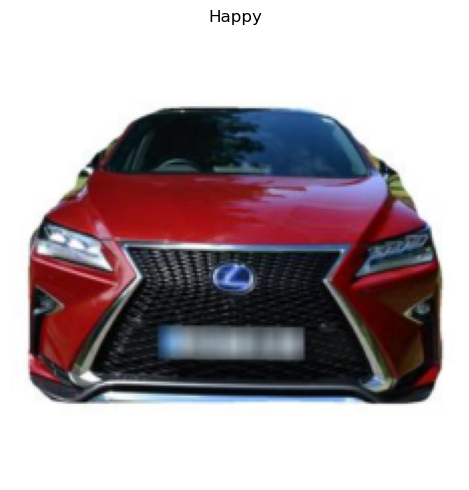

In [60]:
visualize_images([TEST_IMAGE_PATH,])

In [44]:
image_paths = [
    "data/images/confirmed_fronts/Lexus/2017/Lexus$$RX 450h$$2017$$Red$$48_24$$468$$image_1.jpg",
    "data/images/confirmed_fronts/Audi/2017/Audi$$Q5$$2017$$Black$$7_20$$1219$$image_5.jpg",
    "data/images/confirmed_fronts/Tesla/2017/Tesla$$Model X$$2017$$White$$90_2$$8$$image_0.jpg",
    "data/images/confirmed_fronts/Toyota/2017/Toyota$$RAV4$$2017$$Silver$$92_34$$164$$image_0.jpg",
    "data/images/confirmed_fronts/Subaru/2017/Subaru$$Outback$$2017$$Black$$86_7$$89$$image_4.jpg",
    "data/images/confirmed_fronts/Bentley/2017/Bentley$$Continental$$2017$$Grey$$10_5$$700$$image_5.jpg"
]

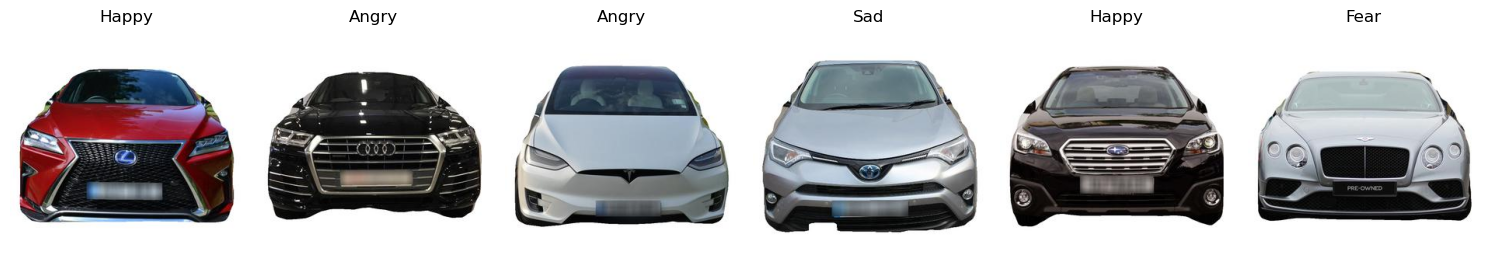

In [45]:
visualize_images(image_paths)

In [16]:
import os

os.listdir("data/images/confirmed_fronts/")

['Volkswagen',
 'Porsche',
 'Bugatti',
 'Mitsubishi',
 'Renault',
 'Ferrari',
 'Ford',
 'Isuzu',
 'McLaren',
 'Daewoo',
 'Perodua',
 'MINI',
 'Noble',
 'Jeep',
 'Mazda',
 'Proton',
 'MG',
 'DS',
 'Bentley',
 'Daihatsu',
 'Lamborghini',
 'Smart',
 'Lotus',
 'Land Rover',
 'Zenos',
 'Saab',
 'Tesla',
 'Hyundai',
 'Kia',
 'Opel',
 'Chevrolet',
 'Abarth',
 'Dacia',
 'Infiniti',
 'Toyota',
 'Cadillac',
 'Nissan',
 'Dodge',
 'Lexus',
 'Audi',
 'Volvo',
 'Corvette',
 'Peugeot',
 'Subaru',
 'Vauxhall',
 'Alfa Romeo',
 'Aston Martin',
 'SKODA',
 'Ssangyong',
 'Chrysler',
 'Maserati',
 'Jaguar',
 'BMW',
 'Fiat',
 'Great Wall',
 'Mercedes-Benz',
 'Rover',
 'Citroen',
 'Honda',
 'Rolls-Royce',
 'Suzuki',
 'MEV',
 'SEAT']

Processing files:   0%|          | 99/61827 [00:14<2:21:01,  7.29it/s]

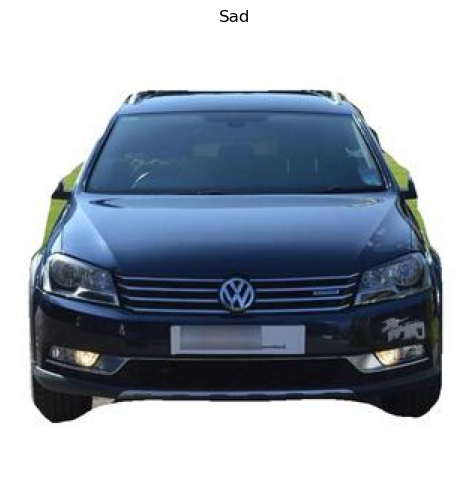

Processing files:   0%|          | 199/61827 [00:28<2:26:12,  7.02it/s]

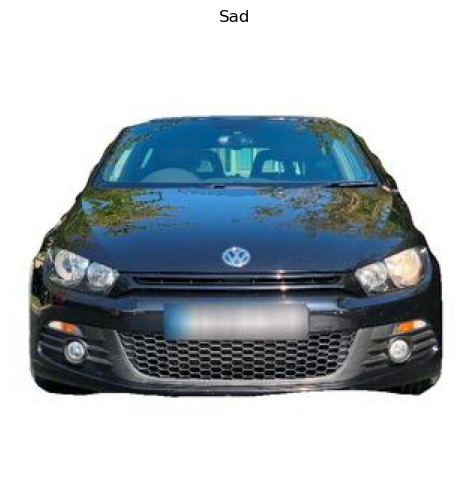

Processing files:   0%|          | 258/61827 [00:37<2:33:31,  6.68it/s]

KeyboardInterrupt: 

In [43]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image

root_dir = 'data/images/confirmed_fronts/'

# Get total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk(root_dir)])

# Create a tqdm object
pbar = tqdm(total=total_files, desc="Processing files")

# Initialize an empty list to store results
results = []

# Counter for visualizing every 100 images
image_counter = 0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        image, label, probs = predict_expression(full_path)
        # Store results
        result = {
            'image_path': full_path,
            'label': label
        }
        # Add probability columns
        for i, prob in enumerate(probs):
            result[f'prob_{i}'] = prob
        
        results.append(result)
        # Visualize every 100 images
        image_counter += 1
        if image_counter % 100 == 0:
            visualize_images([full_path,])
        
        pbar.update(1)

pbar.close()

# Create DataFrame from results
df = pd.DataFrame(results)

# Display the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
df.to_csv('expression_results.csv', index=False)